In [26]:
%matplotlib widget
import torch
import os
os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from diffSPH.v2.modules.viscosity import computeViscosityParameter, setViscosityParameters
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime
from diffSPH.v2.util import computeStatistics
import tomli

In [27]:
configurationFile = './configurations/01_tgv.toml'

with open(configurationFile, 'r') as f:
    config = f.read()

config = tomli.loads(config)

In [28]:
# config

In [29]:
nx = 128
L = 1
u_mag = 2
k = 1 * np.pi
TGV_override = False
targetRe = 2000

config['domain']['minExtent'] = -L
config['domain']['maxExtent'] =  L

config['particle'] = {'nx' : nx}
config['fluid'] = {'cs' : u_mag * 10}
config['compute'] = {'device': 'cuda'}
config['plot']['export'] = True
config['kernel'] = {'name': 'Wendland2'}
# config['kernel']['targetNeighbors'] = 100
# config['compute'] = {'device': 'cpu'}

config = parseDefaultParameters(config)
config = parseModuleParameters(config)
setViscosityParameters(config, targetRe, L, u_mag)
config['integration']['scheme'] = 'symplecticEuler'

print(rf'Re = {config["diffusion"]["Re"]}, $\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$, $\alpha = {config["diffusion"]["alpha"]}$')


Re = 1999.9998779296875, $\nu_{sph} = 0.0020000000949949026$, $\alpha = 0.010793905705213547$


In [30]:
# def sampleNoisyParticles(noiseConfig, config, sdfs = [], randomizeParticles = False):
#     particlesA, volumeA = sampleRegular(config['particle']['dx'], config['domain']['dim'], config['domain']['minExtent'], config['domain']['maxExtent'], config['kernel']['targetNeighbors'], config['simulation']['correctArea'], config['kernel']['function'])
#     particlesA = particlesA.to(config['compute']['device'])
#     volumeA = volumeA.to(config['compute']['device'])
    
#     area = (4 / config['particle']['nx']**2)
#     area = volumeA
#     grid, noiseSimplex = sampleNoise(noiseConfig)

#     noiseState = {}
#     noiseState['numParticles'] = particlesA.shape[0]
#     # noiseState['timestep'] = 0
#     # noiseState['time'] = 0.
#     # noiseState['dt'] = config['timestep']['dt']
#     noiseState['positions'] = particlesA
#     noiseState['areas'] = particlesA.new_ones(particlesA.shape[0]) * area
#     noiseState['pressures'] = particlesA.new_zeros(particlesA.shape[0])
#     noiseState['divergence'] = particlesA.new_zeros(particlesA.shape[0])
#     noiseState['masses'] = noiseState['areas'] * config['fluid']['rho0']
#     noiseState['supports'] = volumeToSupport(area, config['kernel']['targetNeighbors'], config['domain']['dim']) * particlesA.new_ones(particlesA.shape[0])
#     noiseState['index'] = torch.arange(particlesA.shape[0], device = particlesA.device)
#     noiseState['densities'] = particlesA.new_ones(particlesA.shape[0]) * config['fluid']['rho0'] 
#     noiseState['velocities'] = particlesA.new_zeros(particlesA.shape[0], config['domain']['dim'])
#     noiseState['accelerations'] = particlesA.new_zeros(particlesA.shape[0], config['domain']['dim'])
#     if len(sdfs) > 0:
#         noiseState['distances'] = particlesA.new_ones(particlesA.shape[0]) * np.inf

#     if randomizeParticles:
#         baseShiftingConfig = copy.deepcopy(config['shifting'])

#         config['shifting']['solver'] = 'BiCGStab_wJacobi'
#         # config['shifting']['solver'] = 'BiCGStab'
#         config['shifting']['maxIterations'] = 64
#         config['shifting']['freeSurface'] = False
#         config['shifting']['summationDensity'] = False
#         config['shifting']['scheme'] = 'IPS'
#         config['shifting']['maxSolveIter'] = 128
#         config['shifting']['initialization'] = 'zero'
#         config['shifting']['threshold'] = 0.5

#         positions = torch.rand(noiseState['positions'].shape, device = noiseState['positions'].device) * 2 - 1
#         shiftState = {
#                 'positions': positions,
#                 'areas': noiseState['areas'],
#                 'densities': noiseState['densities'],\
#                 'numParticles': noiseState['numParticles'],
#                 'velocities': noiseState['velocities'],
#                 'masses': noiseState['masses'],
#                 'supports': noiseState['supports'],
#             }
#         dx, states = solveShifting({
#             'fluid':shiftState
#         }, config)
#         shiftState['positions'] = positions + dx

#         config['shifting'] = baseShiftingConfig

#         x = shiftState['positions'].clone()

#         periodic = config['domain']['periodicity']
#         minDomain = config['domain']['minExtent']
#         maxDomain = config['domain']['maxExtent']
#         periodicity = torch.tensor([False] * x.shape[1], dtype = torch.bool).to(x.device)
#         if isinstance(periodic, torch.Tensor):
#             periodicity = periodic
#         if isinstance(periodic, bool):
#             periodicity = torch.tensor([periodic] * x.shape[1], dtype = torch.bool).to(x.device)

#         mod_positions = torch.stack([x[:,i] if not periodic_i else torch.remainder(x[:,i] - minDomain[i], maxDomain[i] - minDomain[i]) + minDomain[i] for i, periodic_i in enumerate(periodicity)], dim = 1)
#         lin_x = (mod_positions[:,0] - minDomain[0]) / (maxDomain[0] - minDomain[0])
#         lin_y = (mod_positions[:,1] - minDomain[1]) / (maxDomain[1] - minDomain[1])

#         gridDim = 128 // 2
#         linearIndex = (torch.round(lin_x * gridDim) + torch.round(lin_y * gridDim) * gridDim).to(torch.int32)
#         sortedIndices = torch.argsort(linearIndex)
#         sortedPositions = mod_positions[sortedIndices]
#         shiftState['positions'] = sortedPositions

#         _, noiseNeighbors = neighborSearch(shiftState, noiseState, config)

#         noise = noiseSimplex.flatten().to(particlesA.device)
#         noiseState['potential'] = sphOperationStates(noiseState, shiftState, (noise, noise), operation = 'interpolate', neighborhood = noiseNeighbors)
#         noiseState['positions'] = shiftState['positions']



#     else:
#         noiseState['potential'] = noiseSimplex.flatten().to(particlesA.device)




#     # mask = torch.ones_like(noiseState['areas'], dtype = torch.bool)
#     # fluid_sdfs = [sdf['sdf'] for sdf in sdfs if sdf['type'] == 'fluid' ]   
#     # mask = None
#     # if len(fluid_sdfs) > 0:
#     #     mask = torch.zeros_like(noiseState['areas'], dtype = torch.bool)

#     #     for sdf_func in fluid_sdfs:
#     #         _, maskA, sdfValues, _ = filterParticlesWithSDF(particlesA, sdf_func, noiseState['supports'][0], -1e-4)
#     #         mask = mask | maskA
#     #         noiseState['distances'] = torch.min(noiseState['distances'], sdfValues)
#     #     mask = mask.to(config['compute']['device'])
#     # noiseState['velocities'][~mask, :] = 0

#     samplings = None
#     if samplings is None:   
#         samplings = ['regular' for _ in sdfs]
#     if not isinstance(samplings, List):
#         samplings = [samplings for _ in sdfs]

#     boundary_sdfs = [sdf['sdf'] for sdf in sdfs if sdf['type'] == 'boundary' ]   
    
#     boundaryParticles, boundaryVolumes, boundaryDistances, boundaryNormals, boundaryBodyIDs, fluidMask = sampleBoundaryParticles(noiseState, boundary_sdfs, config, samplings)
#     for k in noiseState.keys():
#         if isinstance(noiseState[k], torch.Tensor):
#             noiseState[k] = noiseState[k][fluidMask]
#     noiseState['numParticles'] = noiseState['positions'].shape[0]
            
#     _, fluidNeighborhood = neighborSearch(noiseState, noiseState, config)

#     noiseState['neighborhood'] = fluidNeighborhood
#     # printState(noiseState)
    
#     # printState(noiseState)

#     # for sdf in boundary_sdfs:
#     #     # _, maskA, _, _ = filterParticlesWithSDF(particlesA, operatorDict['invert'](sdf), config['particle']['support'], -1e-4)
#         # noiseState['potential'] = filterPotentialField(operatorDict['invert'](sdf), noiseState, config, kind = 'divergenceFree')
#         # noiseState['potential'] = filterPotentialField(sdf, noiseState, config, kind = 'divergenceFree')


#     noiseState['velocities'], noiseState['divergence'] = sampleVelocityField(noiseState, noiseState['neighborhood'])
#     # if mask is None:
#         # mask = torch.ones_like(noiseState['potential'], dtype = torch.bool)
#     # for sdf_func in boundary_sdfs:
#         # _, maskA, _, _ = filterParticlesWithSDF(particlesA, operatorDict['invert'](sdf), config['particle']['support'], -1e-4)
#         # _, maskA, _, _ = filterParticlesWithSDF(particlesA, sdf, config['particle']['support'], -1e-4)
#         # mask = mask & maskA
#     # noiseState['velocities'][~mask, :] = 0

#     _, noiseState['numNeighbors'] = countUniqueEntries(fluidNeighborhood['indices'][0], noiseState['positions'])

#     return noiseState, None

In [31]:

from torch.profiler import profile, record_function, ProfilerActivity
from diffSPH.v2.modules.inletOutlet import processInlet, processOutlet, processForcing
from diffSPH.v2.plotting import plotRegions
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict
from diffSPH.v2.sampling import find_contour

ngrid = 255
x = torch.linspace(config['domain']['minExtent'][0], config['domain']['maxExtent'][0], ngrid, dtype = torch.float32)
y = torch.linspace(config['domain']['minExtent'][1], config['domain']['maxExtent'][1], ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1/2]).to(points.device))
inletSDF = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1]).to(points.device))
outletSDF = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/4,1.5]).to(points.device))
outletRegion = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/4,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

inner = lambda points: getSDF('box')['function'](points, torch.tensor([1,1]).to(points.device))
outer = lambda points: getSDF('box')['function'](points, torch.tensor([1 + config['particle']['dx'] * boundary_width,1 + config['particle']['dx'] * boundary_width]).to(points.device))
outer = operatorDict['invert'](outer)
sdf = operatorDict['union'](inner, outer)
boundary_sdf = operatorDict['invert'](inner)


fluid_sdf = lambda points: getSDF('box')['function'](points, torch.tensor([1,1]).to(points.device))
# fluid_sdf = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/2, - 1/2]))


regions = [
    # {
    #     'sdf': inletSDF,
    #     'type': 'inlet',
    #     'velocity': torch.tensor([1,0.]),
    #     'particles': sampleParticles(config, sdfs = [inletSDF])[0],
    #     'contour': find_contour(inletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },
    # {
    #     'sdf': inletSDF,
    #     'type': 'forcing',
    #     'forcingMode': 'immediate',
    #     'velocity': torch.tensor([1,0.]),
    #     'particles': sampleParticles(config, sdfs = [inletSDF])[0],
    #     'contour': find_contour(inletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },{
    #     'sdf': outletSDF,
    #     'type': 'outlet',
    #     'velocity': torch.tensor([0.,0.]),
    #     'particles': sampleParticles(config, sdfs = [outletSDF])[0],
    #     'contour': find_contour(outletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },{
    #     'sdf': outletRegion,
    #     'type': 'mirror',
    #     'velocity': torch.tensor([0.,0.]),
    #     'particles': sampleParticles(config, sdfs = [outletRegion])[0],
    #     'contour': find_contour(outletRegion(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },
{
        'sdf': fluid_sdf,
        'type': 'fluid',
        'velocity': torch.tensor([0.,0.]),
        # 'particles': sampleParticles(config, sdfs = [fluid_sdf])[0],
        'contour': find_contour(fluid_sdf(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    }
    ]

config['regions'] = regions

# fig, axis = plt.subplots(1,2, figsize = (15,5), squeeze = False)
# setPlotBaseAttributes(axis[0,0], config)
# # setPlotBaseAttributes(axis[0,1], config)

# # plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,0])


In [32]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict

# particleState, mask = sampleParticles(config, sdfs = [])
particleState, mask = sampleNoisyParticles(config['noise'], config, sdfs = regions, randomizeParticles = False)

priorState = None
particleState['velocities'][:,0] =  u_mag * torch.cos(k * particleState['positions'][:,0]) * torch.sin(k * particleState['positions'][:,1])
particleState['velocities'][:,1] = -u_mag * torch.sin(k * particleState['positions'][:,0]) * torch.cos(k * particleState['positions'][:,1])

# u_max = torch.linalg.norm(particleState['velocities'], dim = 1).max()
# particleState['velocities'] = particleState['velocities'] / (u_max + 1e-7) * u_mag
Ek0 = 0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(particleState['velocities'], dim = -1)**2

initialVelocities = particleState['velocities'].clone()

particleState['Eks'] =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2)
particleState['E_k'] = particleState['Eks'].sum().cpu().detach().item()


In [33]:
from diffSPH.v2.modules.pressureForce import computePressureAccelSwitch
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne

# from diffSPH.v2.modules.neighborhood import fluidNeighborSearch
from diffSPH.v2.sphOps import sphOperationStates
from diffSPH.v2.util import countUniqueEntries
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceBarecasco
from diffSPH.v2.math import pinv2x2, scatter_sum
from diffSPH.v2.sphOps import sphOperation, sphOperationStates
from diffSPH.v2.math import scatter_sum
from diffSPH.v2.modules.densityDiffusion import renormalizedDensityGradient, computeDensityDeltaTerm
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
# from diffSPH.v2.modules.momentumEquation import computeMomentumEquation
from diffSPH.v2.modules.viscosity import computeViscosity
from diffSPH.v2.modules.pressureEOS import computeEOS
from diffSPH.v2.modules.pressureForce import computePressureAccel
from diffSPH.v2.modules.boundaryViscosity import computeViscosity_Boundary
from diffSPH.v2.modules.gravity import computeGravity
from diffSPH.v2.modules.sps import computeSPSTurbulence
from torch.profiler import record_function


from diffSPH.v2.modules.density import computeDensity
import torch
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.normalizationMatrices import computeCovarianceMatrices

def callModule(state, module, config, direction = 'all', reduce = 'sum', **kwargs):
    if not config['boundary']['active']:
        return module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs), None
    if direction == 'all':
        if not config['boundary']['active']:
            return module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs), None
        else:
            ftf = module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs)
            # print(f' fluid -> fluid: {ftf.shape}, mean: {ftf.mean()}, min: {ftf.min()}, max: {ftf.max()}')
            btb = module(state['boundary'], state['boundary'], state['boundary']['neighborhood'], config, **kwargs)
            # print(f' boundary -> boundary: {btb.shape}, mean: {btb.mean()}, min: {btb.min()}, max: {btb.max()}')
            btf = module(state['fluid'], state['boundary'], state['boundaryToFluidNeighborhood'], config, **kwargs)
            # print(f' boundary -> fluid: {btf.shape}, mean: {btf.mean()}, min: {btf.min()}, max: {btf.max()}')
            ftb = module(state['boundary'], state['fluid'], state['fluidToBoundaryNeighborhood'], config, **kwargs)
            # print(f' fluid -> boundary: {ftb.shape}, mean: {ftb.mean()}, min: {ftb.min()}, max: {ftb.max()}')

            if reduce == 'sum':
                return ftf + btf, btb + ftb
            elif reduce == 'min':
                return torch.min(ftf, btf), torch.min(btb, ftb)
            elif reduce == 'max':
                return torch.max(ftf, btf), torch.max(btb, ftb)
            else:
                raise ValueError(f"Invalid reduce {reduce}")
            
    if direction == 'fluid':
        return module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs), None
    if direction == 'fluidwBoundary':
        ftf = module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs)
        btf = module(state['fluid'], state['boundary'], state['boundaryToFluidNeighborhood'], config, **kwargs)
        if reduce == 'sum':
            return ftf + btf, None
        elif reduce == 'min':
            return torch.min(ftf, btf), None
        elif reduce == 'max':
            return torch.max(ftf, btf), None
        else:
            raise ValueError(f"Invalid reduce {reduce}")
    if direction == 'boundary':
        return None, module(state['boundary'], state['boundary'], state['boundary']['neighborhood'], config, **kwargs)
    if direction == 'boundarywFluid':
        btb = module(state['boundary'], state['boundary'], state['boundary']['neighborhood'], config, **kwargs)
        ftb = module(state['boundary'], state['fluid'], state['fluidToBoundaryNeighborhood'], config, **kwargs)
        if reduce == 'sum':
            return None, btb + ftb
        elif reduce == 'min':
            return None, torch.min(btb, ftb)
        elif reduce == 'max':
            return None, torch.max(btb, ftb)
        else:
            raise ValueError(f"Invalid reduce {reduce}")
    if direction == 'fluidToBoundary':
        return None, module(state['boundary'], state['fluid'], state['fluidToBoundaryNeighborhood'], config, **kwargs)
    if direction == 'boundaryToFluid':
        return module(state['fluid'], state['boundary'], state['boundaryToFluidNeighborhood'], config, **kwargs), None
    if direction == 'oneWay':
        ftf = module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs)
        btf = module(state['fluid'], state['boundary'], state['boundaryToFluidNeighborhood'], config, **kwargs)
        if reduce == 'sum':
            return ftf + btf, None
        elif reduce == 'min':
            return torch.min(ftf, btf), None
        elif reduce == 'max':
            return torch.max(ftf, btf), None
        else:
            raise ValueError(f"Invalid reduce {reduce}")
    raise ValueError(f"Invalid direction {direction}")


from diffSPH.v2.simulationSchemes.deltaPlus import callModule
from diffSPH.v2.modules.pressureForce import computePressureAccelSwitch
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne

# from diffSPH.v2.modules.neighborhood import fluidNeighborSearch
from diffSPH.v2.sphOps import sphOperationStates, LiuLiuConsistent
from diffSPH.v2.util import countUniqueEntries
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceBarecasco
from diffSPH.v2.math import pinv2x2, scatter_sum
from diffSPH.v2.sphOps import sphOperation, sphOperationStates
from diffSPH.v2.math import scatter_sum
from diffSPH.v2.modules.densityDiffusion import renormalizedDensityGradient, computeDensityDeltaTerm, densityGradient
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
# from diffSPH.v2.modules.momentumEquation import computeMomentumEquation
# from diffSPH.v2.modules.viscosity import computeViscosity
from diffSPH.v2.modules.pressureEOS import computeEOS
from diffSPH.v2.modules.pressureForce import computePressureAccel
from diffSPH.v2.modules.gravity import computeGravity
from diffSPH.v2.modules.sps import computeSPSTurbulence
from torch.profiler import record_function


from diffSPH.v2.modules.density import computeDensity
import torch
from diffSPH.v2.modules.neighborhood import neighborSearch, searchNeighbors
from diffSPH.v2.modules.normalizationMatrices import computeCovarianceMatrices
# from diffSPH.v2.modules.inletOutlet import buildOutletGhostParticles
from diffSPH.v2.modules.mDBC import buildBoundaryGhostParticles, mDBCDensity
from diffSPH.v2.modules.inletOutlet import buildOutletGhostParticles
from diffSPH.v2.modules.momentumEquation import computeMomentumEquation



def computePressureAccelNonConservative(stateA, stateB, neighborhood, config):
    with record_function("[SPH] - Pressure Acceleration (1/rho nabla p)"):
        (i,j) = neighborhood['indices']
        p_i = stateA['pressures'][i]
        p_j = stateB['pressures'][j]
        p_ij = p_j - p_i
        p_ij = p_j + p_i

        masses = (stateA['masses'], stateB['masses'])
        densities = (stateA['densities'], stateB['densities'])
        i, j = neighborhood['indices']
        gradKernels = neighborhood['gradients']
        numParticles = stateA['numParticles']

        k = (masses[1][j] / (densities[0][i] * densities[1][j] )).view(-1,1) * gradKernels
        qij = p_ij
        kq = torch.einsum('n... , nd -> n...d', qij, k)

        return -scatter_sum(kq, i, dim = 0, dim_size = numParticles)

        return -sphOperationStates(stateA, stateB, p_ij, operation = 'gradient', gradientMode='summation') / stateA['densities'].view(-1,1)
        return -sphOperationStates(stateA, stateB, (stateA['pressures'], stateB['pressures']), operation = 'gradient', gradientMode='summation', neighborhood= neighborhood) / stateA['densities'].view(-1,1)
    

def checkNaNs(state):
    for key in state:
        if isinstance(state[key], torch.Tensor):
            if torch.any(torch.isnan(state[key])):
                print(f'NaNs in {key}')
                raise RuntimeError(f'NaNs in {key}')
        if not isinstance(state[key], dict):
            continue
        for subkey in state[key]:
            if not isinstance(state[key][subkey], torch.Tensor):
                continue
            if torch.any(torch.isnan(state[key][subkey])):
                print(f'NaNs in {key} - {subkey}')
                raise RuntimeError(f'NaNs in {key} - {subkey}')
def checkNaN(tensor, name):
    if torch.any(torch.isnan(tensor)) or torch.any(torch.isinf(tensor)) or torch.any(torch.abs(tensor) > 1e10):
        print(f'NaNs in {name}, number of NaNs: {torch.sum(torch.isnan(tensor))}')
        raise RuntimeError(f'NaNs in {name}, number of NaNs: {torch.sum(torch.isnan(tensor))}')


In [34]:
from diffSPH.v2.math import scatter_sum

def computeDeltaU(particleState, config):
    with record_function("[Shifting] - Delta+ Shifting"):
        W_0 = config['kernel']['function'].kernel(torch.tensor(config['particle']['dx'] / config['particle']['support'] * config['kernel']['kernelScale']), torch.tensor(config['particle']['support']), dim = config['domain']['dim'])
        W_0 = config['kernel']['function'].kernel(torch.tensor(config['particle']['dx'] / config['particle']['support']), torch.tensor(config['particle']['support']), dim = config['domain']['dim'])

        (i,j) = particleState['neighborhood']['indices']
        k = particleState['neighborhood']['kernels'] / W_0
        gradK = particleState['neighborhood']['gradients']

        # print(f'Kernels: {k.shape}, mean: {k.mean()}, gradK: {gradK.shape}, mean: {gradK.mean()}')

        R = config['shifting']['R']
        n = config['shifting']['n']
        term = (1 + R * torch.pow(k, n))
        densityTerm = particleState['masses'][j] / (particleState['densities'][j])
        phi_ij = 1

        scalarTerm = term * densityTerm * phi_ij
        shiftAmount = scatter_sum(scalarTerm.view(-1,1) * gradK, i, dim = 0, dim_size = particleState['positions'].shape[0])

        CFL = config['shifting']['CFL']
        if config['shifting']['computeMach'] == False:
            Ma = 0.1
        else:
            Ma = torch.amax(torch.linalg.norm(particleState['velocities'], dim = -1)) #/ config['fluid']['cs']
        shiftScaling = - Ma * (particleState['supports'] / config['kernel']['kernelScale'] * 2)#**2
        # print(f'Shift: {shiftAmount.abs().max()}, Scaling: {shiftScaling.shape}')
        # print(particleState['fluidSupports'])
        shiftScale = torch.linalg.norm(shiftAmount, dim = -1) * shiftScaling
        clampedShiftScale = torch.min(shiftScale, Ma / 2)

        return  shiftAmount * (shiftScaling * clampedShiftScale / (shiftScale + 1e-7)).view(-1,1)


In [51]:

def simulationStep(state, config):
    if config['compute']['checkNaN']:
        checkNaNs(state)


    with record_function("[SPH] - deltaSPH (1 - Neighbor Search)"):
        searchNeighbors(state, config)
        # torch.cuda.synchronize()

    with record_function("[SPH] - deltaSPH (2 - Ghost Particle Creation)"):
        if config['boundary']['active'] and 'boundary' in state:
            state['boundaryGhost'] = buildBoundaryGhostParticles(state, config)
        if 'regions' in  config and config['regions'] is not None:
            state['outletGhost'] = buildOutletGhostParticles(config['regions'], state, config)
        # torch.cuda.synchronize()
        
    with record_function("[SPH] - deltaSPH (3 - Density Computation)"):
        if config['simulation']['densityScheme'] == 'summation':
            if config['boundary']['active']:
                state['fluid']['densities'], state['boundary']['densities'] = callModule(state, computeDensity, config, 'all')
            else:
                state['fluid']['densities'], _ = callModule(state, computeDensity, config, 'fluid')
            torch.cuda.synchronize()
        # print(f'Density Min: {state["fluid"]["densities"].min()}, Max: {state["fluid"]["densities"].max()}')
        if config['boundary']['active']:
            with record_function("[SPH] - deltaSPH (3 - mDBC Density Estimate)"):
                state['boundary']['densities'], state['boundaryGhost']['densities'] = mDBCDensity(state, config)
                # state['boundary']['densities'] += torch.abs(state['boundary']['distances']) / config['particle']['support'] * 2
                # torch.cuda.synchronize()
        if config['compute']['checkNaN']:
            checkNaN(state['fluid']['densities'], 'densities')
        if config['boundary']['active']:
            if config['compute']['checkNaN']:
                checkNaN(state['boundary']['densities'], 'boundary - densities')
    if 'regions' in config and config['regions'] is not None:
        if state['outletGhost'] is not None:
            with record_function("[SPH] - deltaSPH (4 - Outlet Processing)"):
                ghostState = state['outletGhost']
                neighbors = ghostState['neighborhood']['indices'][0]
                solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['densities'])

                cond = torch.logical_and(ghostState['numNeighbors'] >= 1, ghostState['sdf_dist'] < 2.5 * config['particle']['support'])
                cond = ghostState['numNeighbors'] >= 10

                def updateQuantity(state, ghostState, quantity, solution, cond):
                    return torch.where(cond, solution[:,0] + torch.einsum('nd, nd -> n', ghostState['sdf_dist'][:,None] * ghostState['sdf_grad'] * 2, solution[:,1:]), quantity)
                state['fluid']['densities'][ghostState['fluidIndex']] = updateQuantity(state, ghostState, state['fluid']['densities'][ghostState['fluidIndex']], solution, cond)
                state['fluid']['outletMarker'] = state['fluid']['densities'].new_zeros(state['fluid']['densities'].shape[0])
                state['fluid']['outletMarker'][ghostState['fluidIndex']] = 1

                solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['velocities'][:,0])
                state['fluid']['velocities'][ghostState['fluidIndex'],0] = updateQuantity(state, ghostState, state['fluid']['velocities'][ghostState['fluidIndex']][:,0], solution, cond)

                
                solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['velocities'][:,1])
                state['fluid']['velocities'][ghostState['fluidIndex'],1] =updateQuantity(state, ghostState, state['fluid']['velocities'][ghostState['fluidIndex']][:,1], solution, cond)

                if config['compute']['checkNaN']:
                    checkNaN(state['fluid']['densities'], 'densities')
                    checkNaN(state['fluid']['velocities'], 'velocities')
                

                # torch.cuda.synchronize()

    with record_function("[SPH] - deltaSPH (5 - Normalization Matrices)"):
        # state['fluid']['covarianceMatrix'], _ = callModule(state, computeCovarianceMatrices, config, 'fluidwBoundary')
        state['fluid']['covarianceMatrix'], _ = callModule(state, computeCovarianceMatrices, config, 'fluidwBoundary')
        if config['compute']['checkNaN']:
            checkNaN(state['fluid']['covarianceMatrix'], 'covarianceMatrix')
        state['fluid']['covarianceMatrix'][state['fluid']['numNeighbors'] < 4,:,:] = torch.eye(2, dtype = state['fluid']['covarianceMatrix'].dtype, device = state['fluid']['covarianceMatrix'].device)[None,:,:]


        state['fluid']['L'], state['fluid']['L.EVs'] = pinv2x2(state['fluid']['covarianceMatrix'])
    
        if config['compute']['checkNaN']:
            checkNaN(state['fluid']['L'], 'L')
            checkNaN(state['fluid']['L.EVs'], 'L.EVs')

        # torch.cuda.synchronize()

    with record_function("[SPH] - deltaSPH (6 - Density Gradient)"):
        state['fluid']['gradRho^L'],_ = callModule(state, renormalizedDensityGradient, config, 'fluid')
        if config['compute']['checkNaN']:
            checkNaN(state['fluid']['gradRho^L'], 'gradRho^L')

        if config['boundary']['active']:
            state['fluid']['gradRho^L'] += callModule(state, densityGradient, config, 'boundaryToFluid')[0]


        # state['boundary']['gradRho^L'] = callModule(state, densityGradient, config, 'boundary')[1]
        # torch.cuda.synchronize()

    with record_function("[SPH] - deltaSPH (7 - Diffusion and Momentum)"):
        state['fluid']['densityDiffusion'], _ = callModule(state, computeDensityDeltaTerm, config, 'fluid')
        if config['compute']['checkNaN']:
            checkNaN(state['fluid']['densityDiffusion'], 'densityDiffusion')
        # config['diffusion']['densityScheme'] = 'deltaSPH
        # state['fluid']['densityDiffusion'] += callModule(state, computeDensityDeltaTerm, config, 'boundaryToFluid')[0]

        # state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')
        # torch.cuda.synchronize()
        if config['boundary']['active']:
            # state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')
            state['fluid']['velocityDiffusion'], state['boundary']['velocityDiffusion'] = callModule(state, computeViscosity, config, 'fluid')

            state['fluid']['boundaryVelocityDiffusion'], _ = callModule(state, computeViscosity_Boundary, config, 'boundaryToFluid')

            state['fluid']['velocityDiffusion'] += state['fluid']['boundaryVelocityDiffusion']

            if config['compute']['checkNaN']:
                checkNaN(state['fluid']['velocityDiffusion'], 'velocityDiffusion')
                # checkNaN(state['boundary']['velocityDiffusion'], 'boundary - velocityDiffusion')

            state['fluid']['momentumEquation'], state['boundary']['momentumEquation'] = callModule(state, computeMomentumEquation, config, 'all')
            if config['compute']['checkNaN']:
                checkNaN(state['fluid']['momentumEquation'], 'momentumEquation')
                # checkNaN(state['boundary']['momentumEquation'], 'boundary - momentumEquation')
        else:
            state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')
            if config['compute']['checkNaN']:
                checkNaN(state['fluid']['velocityDiffusion'], 'velocityDiffusion')

            state['fluid']['momentumEquation'], _ = callModule(state, computeMomentumEquation, config, 'fluid')
            if config['compute']['checkNaN']:
                checkNaN(state['fluid']['momentumEquation'], 'momentumEquation')
        # torch.cuda.synchronize()
        state['fluid']['pressures'] = computeEOS(state['fluid'], config)
        if config['compute']['checkNaN']:
                checkNaN(state['fluid']['pressures'], 'pressures')

        if 'boundary' in state:
            state['boundary']['pressures'] = computeEOS(state['boundary'], config)
            if config['compute']['checkNaN']:
                checkNaN(state['boundary']['pressures'], 'boundary - pressures')

    with record_function("[SPH] - deltaSPH (8 - Pressure Forces)"):
        if 'boundary' in state:
            state['fluid']['pressureAccel'], state['boundary']['pressureAccel'] = callModule(state, computePressureAccel, config, 'all')
            state['fluid']['pressureAccel'], _ = callModule(state, computePressureAccelNonConservative, config, 'fluid')
            if config['compute']['checkNaN']:
                # print(f'Pressure Min: {state["fluid"]["pressureAccel"].min()}, Max: {state["fluid"]["pressureAccel"].max()}')
                # print(f'Density Min: {state["fluid"]["densities"].min()}, Max: {state["fluid"]["densities"].max()}')
                # if 'outletMarker' in state['fluid']:
                #     print('In Mask:')
                #     print(f'Pressure Min: {state["fluid"]["pressureAccel"][state["fluid"]["outletMarker"] == 1].min()}, Max: {state["fluid"]["pressureAccel"][state["fluid"]["outletMarker"] == 1].max()}')
                #     print(f'Density Min: {state["fluid"]["densities"][state["fluid"]["outletMarker"] == 1].min()}, Max: {state["fluid"]["densities"][state["fluid"]["outletMarker"]== 1].max()}')

                #     print('Out Mask:')
                #     print(f'Pressure Min: {state["fluid"]["pressureAccel"][state["fluid"]["outletMarker"] == 0].min()}, Max: {state["fluid"]["pressureAccel"][state["fluid"]["outletMarker"] == 0].max()}')
                #     print(f'Density Min: {state["fluid"]["densities"][state["fluid"]["outletMarker"] == 0].min()}, Max: {state["fluid"]["densities"][state["fluid"]["outletMarker"] == 0].max()}')


                checkNaN(state['fluid']['pressureAccel'], 'pressureAccel')
                checkNaN(state['boundary']['pressureAccel'], 'boundary - pressureAccel')
        else:
            state['fluid']['pressureAccel'], _ = callModule(state, computePressureAccel, config, 'fluid')
            # state['fluid']['pressureAccel'], _ = callModule(state, computePressureAccelNonConservative, config, 'fluid')
            checkNaN(state['fluid']['pressureAccel'], 'pressureAccel')
        # torch.cuda.synchronize()
    # state['fluid']['divergence'], state['boundary']['divergence'] = callModule(state, computePressureAccel, config, 'all')

    with record_function("[SPH] - deltaSPH (9 - External Forcing)"):
        state['fluid']['gravityAccel'] = computeGravity(state['fluid'], config)
        if config['compute']['checkNaN']:
            checkNaN(state['fluid']['gravityAccel'], 'gravityAccel')
        # torch.cuda.synchronize()

    # if config['SPS']['active']:
    #     with record_function("[SPH] - deltaSPH (7 - SPS Turbulence)"):
    #         state['fluid']['fluidSPSTurbulence'] = computeSPSTurbulence(simulationState, config)
    # torch.cuda.synchronize()

    with record_function("[SPH] - deltaSPH (10 - Integration)"):
        dudt = state['fluid']['pressureAccel'] + state['fluid']['gravityAccel'] + state['fluid']['velocityDiffusion']
        drhodt = state['fluid']['momentumEquation'] + state['fluid']['densityDiffusion']

        # print('Momentum Term: Mean - ', state['fluid']['momentumEquation'].mean(), 'Max - ', state['fluid']['momentumEquation'].max(), 'Min - ', state['fluid']['momentumEquation'].min(), 'Sum: ', state['fluid']['momentumEquation'].sum())
        # print('Density Term: Mean - ', state['fluid']['densityDiffusion'].mean(), 'Max - ', state['fluid']['densityDiffusion'].max(), 'Min - ', state['fluid']['densityDiffusion'].min(), 'Sum: ', state['fluid']['densityDiffusion'].sum())
        
        delta_u = computeDeltaU(state['fluid'], config) #/ state['dt']

        # print(f'Shift magnitude: {torch.linalg.norm(delta_u, dim = -1).min()} | {torch.linalg.norm(delta_u, dim = -1).mean()} | {torch.linalg.norm(delta_u, dim = -1).max()}')

        # rho_delta_u = state['fluid']['densities'].view(-1,1) * delta_u
        # cross = torch.einsum('nu, nv -> nuv', state['fluid']['velocities'], delta_u)
        # transport_velocity = state['fluid']['velocities'] + delta_u

        # div_delta_u = sphOperationStates(state['fluid'], state['fluid'], (delta_u, delta_u), operation = 'divergence', neighborhood = state['fluid']['neighborhood'], gradientMode='difference')
        # div_rho_delta_u = sphOperationStates(state['fluid'], state['fluid'], (rho_delta_u, rho_delta_u), operation = 'divergence', neighborhood = state['fluid']['neighborhood'], gradientMode='summation')
        # div_cross = sphOperationStates(state['fluid'], state['fluid'], (cross, cross), operation = 'divergence', neighborhood = state['fluid']['neighborhood'], gradientMode='summation', divergenceMode = 'div')

        # divergence = sphOperationStates(state['fluid'], state['fluid'], (transport_velocity, transport_velocity), operation = 'divergence', neighborhood = state['fluid']['neighborhood'], gradientMode='difference')
        # # divergence = sphOperationStates(state['fluid'], state['fluid'], (state['fluid']['velocities'], state['fluid']['velocities']), operation = 'divergence', neighborhood = state['fluid']['neighborhood'], gradientMode='difference')

        # drhodt = - state['fluid']['densities'] * divergence + div_rho_delta_u + state['fluid']['densityDiffusion']
        # dudt += div_cross - state['fluid']['velocities'] * div_delta_u.view(-1,1)

        # state['fluid']['drhodt'] = drhodt
        # state['fluid']['dudt'] = dudt

        if config['compute']['checkNaN']:
            checkNaN(dudt, 'dudt')
            checkNaN(drhodt, 'drhodt')
        

        if 'regions' in config and  config['regions'] is not None:
            if state['outletGhost'] is not None:
                dudt[ghostState['fluidIndex'],:] = 0
                drhodt[ghostState['fluidIndex']] = 0

                    
                # bi = torch.unique(state['boundaryToFluidNeighborhood']['indices'][0])
                # oi = state['outletGhost']['fluidIndex']

                # hasBoundaryNeighbors = torch.zeros(state['fluid']['numParticles'], dtype = torch.bool, device = state['fluid']['positions'].device)
                # hasBoundaryNeighbors[bi] = True

                # hasOutletNeighbors = torch.zeros(state['fluid']['numParticles'], dtype = torch.bool, device = state['fluid']['positions'].device)
                # hasOutletNeighbors[oi] = True

                # mask = torch.logical_and(hasOutletNeighbors, hasBoundaryNeighbors)
                # indices = torch.arange(state['fluid']['numParticles'], device = state['fluid']['positions'].device)[mask]

                # # print(indices)

                # projectedVelocities = state['fluid']['velocities'].clone()
                # normal = torch.Tensor([0.,1.]).to(projectedVelocities.device)
                # projectedVelocities[indices] = projectedVelocities[indices] - torch.einsum('n, d -> nd', torch.einsum('nd, d -> n', state['fluid']['velocities'][indices], normal), normal)

                # dudt_ = -(projectedVelocities - state['fluid']['velocities']) / state['timestep']
                # dudt[indices] = dudt_[indices]
                # # state['fluid']['velocities'][indices] = projectedVelocities[indices] - torch.einsum('n, d -> nd', torch.einsum('nd, d -> n', state['fluid']['velocities'][indices], normal), normal)



        if 'boundary' not in state:
            return (state['fluid']['velocities'].clone(), dudt, drhodt), (None, None, None)
            return (state['fluid']['velocities'].clone() + delta_u, dudt, drhodt), (None, None, None)
        # torch.cuda.synchronize()   
        boundary_dudt = state['boundary']['pressureAccel'] #+ state['boundary']['velocityDiffusion']
        boundary_drhodt = torch.zeros_like(state['boundary']['densities'])#state['boundary']['momentumEquation'] *0

        # return (state['fluid']['velocities'].clone() + delta_u, dudt, drhodt), (state['boundary']['velocities'].clone(), None, boundary_drhodt)
        return (state['fluid']['velocities'].clone(), dudt, drhodt), (state['boundary']['velocities'].clone(), None, boundary_drhodt)
# from diffSPH.parameter import Parameter
# def getParameters():
#     return [
#         Parameter('deltaSPH', 'pressureSwitch', bool, False, required = False, export = True, hint = 'Switches the pressure force calculation to the Antuono Correction'),
#     ]


from torch.profiler import profile, record_function, ProfilerActivity


In [52]:
config['integration']

{'scheme': 'RK4'}

In [53]:
# from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep
from diffSPH.v2.modules.momentumEquation import computeMomentumEquation
from diffSPH.v2.modules.neighborhood import searchNeighbors

from diffSPH.v2.sampling import generateInitialConditions

# initialState = generateInitialConditions(particleState, config)
initialState = {
    'fluid': particleState,
    'time': 0.0,
    'timestep': 0,
    'dt': torch.tensor(5e-4, device = config['compute']['device']),
}

# initialState['fluid']['positions'] += torch.randn_like(initialState['fluid']['positions']) * 0.1 * config['particle']['dx']

# config['shifting']['scheme'] = 'IPS'
# config['shifting']['solver'] = 'BiCG'
# config['shifting']['tol'] = 1e-3
# config['shifting']['rtol'] = 1e-3
# config['shifting']['maxIterations'] = 32
# config['shifting']['preconditioner'] = 'Jacobi'
# config['shifting']['verbose'] = True
# # config['shifting']['threshold'] = 0.5
# config['shifting']['solverThreshold'] = config['particle']['dx'] * 0.5

# dx, _ = solveShifting(initialState, config)
# initialState['fluid']['positions'] += dx

# initialState['fluid']['velocities'][:,0] =  u_mag * torch.cos(k * initialState['fluid']['positions'][:,0]) * torch.sin(k * initialState['fluid']['positions'][:,1])
# initialState['fluid']['velocities'][:,1] = -u_mag * torch.sin(k * initialState['fluid']['positions'][:,0]) * torch.cos(k * initialState['fluid']['positions'][:,1])


perennialState = copy.deepcopy(initialState)

# perennialState['fluid']['positions'] += torch.randn_like(perennialState['fluid']['positions']) * 0.01 * config['particle']['dx']
config['integration']['scheme'] = 'RK4'
config['dfsph']['maxIters'] = 512
config['dfsph']['errorThreshold'] = 5e-4
config['dfsph']['omega'] = 0.33

config['timestep']['dt'] = 5e-4
config["simulation"]["timestamp"] = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")

perennialState['dt'] = 5e-4
perennialState['fluid']['densities'][:] = config['fluid']['rho0']

priorState = None
perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
perennialState['time'] += perennialState['dt']

searchNeighbors(perennialState, config)
div = computeMomentumEquation(perennialState['fluid'], perennialState['fluid'], perennialState['fluid']['neighborhood'], config)

In [54]:

# perennialState['fluid']['velocities'][:,0] =  u_mag * torch.cos(k * perennialState['fluid']['positions'][:,0]) * torch.sin(k * perennialState['fluid']['positions'][:,1])
# perennialState['fluid']['velocities'][:,1] = -u_mag * torch.sin(k * perennialState['fluid']['positions'][:,0]) * torch.cos(k * perennialState['fluid']['positions'][:,1])

# searchNeighbors(perennialState, config)
# div = computeMomentumEquation(perennialState['fluid'], perennialState['fluid'], perennialState['fluid']['neighborhood'], config)

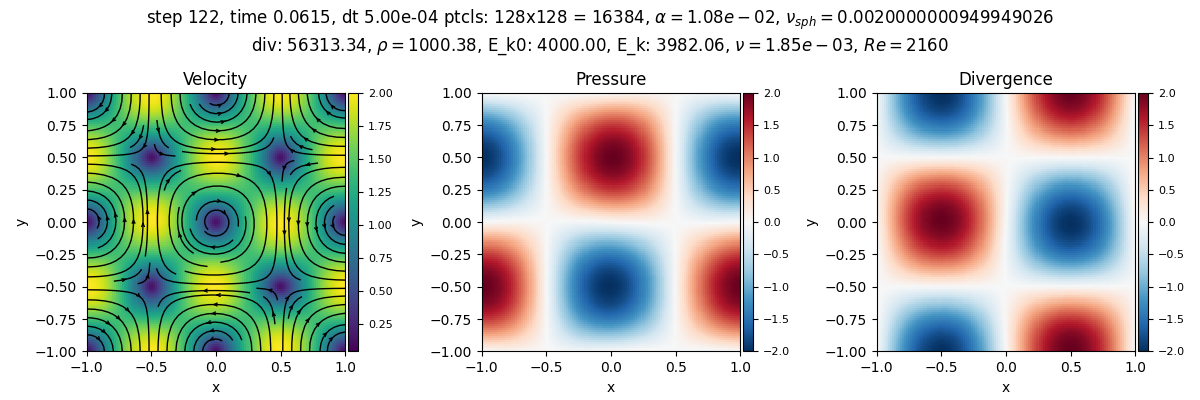

In [58]:
from diffSPH.v2.plotting import prepVisualizationState, visualizeParticleQuantity
from diffSPH.v2.plotting import exportPlot, postProcessPlot
fig, axis = plt.subplots(1,3, figsize = (12,4), squeeze = False)

visualizationState = prepVisualizationState(perennialState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

s = 0.25

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
                                      'velocities',
                                      mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=True, cmap = 'viridis', title = 'Velocity', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = True)
quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
                                      'velocities',
                                      mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu_r', streamLines = False, operation = None, title = 'Pressure', plotBoth = False, which = 'fluid', midPoint = 0)

gt_ux = u_mag * torch.cos(k * perennialState['fluid']['positions'][:,0]) * torch.sin(k * perennialState['fluid']['positions'][:,1])
gt_uy = -u_mag * torch.sin(k * perennialState['fluid']['positions'][:,0]) * torch.cos(k * perennialState['fluid']['positions'][:,1])
diff_u = torch.linalg.norm(perennialState['fluid']['velocities'] - torch.stack([gt_ux, gt_uy], dim = 1), dim = -1)


ones = torch.ones_like(perennialState['fluid']['positions'][:,0])
one_interp = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (ones, ones), operation = 'interpolate', neighborhood = perennialState['fluid']['neighborhood'], gradientMode='difference')
m_tilde = 1 / one_interp
rho = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (m_tilde, m_tilde), operation = 'interpolate', neighborhood = perennialState['fluid']['neighborhood'], gradientMode='difference')



l2Plot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
                                      'velocities',
                                      mapping = '.y', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu_r', streamLines = False, operation = None, title = 'Divergence', plotBoth = False, which = 'fluid', midPoint = 0)

E_k0 =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2).sum().detach().cpu().numpy()
E_k = (0.5 * torch.sum(perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = 1)**2)).sum().detach().cpu().numpy()
nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
Re = u_mag * 2 / nu_total

fig.suptitle(f'step {perennialState["timestep"]}, time {perennialState["time"]:.4g}, dt {perennialState["dt"]:.2e} ptcls: {nx}x{nx} = {nx**2}, $\\alpha = {config["diffusion"]["alpha"]:.2e}$, $\\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$\ndiv: {div.sum():.2f}, $\\rho = {perennialState["fluid"]["densities"].mean().cpu().detach().numpy():.2f}$, E_k0: {E_k0:.2f}, E_k: {E_k:.2f}, $\\nu = {nu_total:.2e}$, $Re = {Re:.4g}$')

fig.tight_layout()

# simulationState['fluid']['actualArea'] = simulationState['fluid']['masses'] / simulationState['fluid']['densities']
# 

# display(fig)

In [57]:
config['integration']['scheme'] = 'symplecticEuler'
from diffSPH.v2.simulationSchemes.deltaPlus import checkNaN
config['shifting']['scheme'] = 'deltaPlus'
config['shifting']['maxIterations'] = 1
priorState = None
for i in tqdm(range(4096)):
    if 'shiftAmount' in perennialState['fluid']:
        del perennialState['fluid']['shiftAmount']
    perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
    dx, _ = solveShifting(perennialState, config)
    numNeighbors = perennialState['fluid']['neighborhood']['numNeighbors']
    # perennialState['fluid']['shiftAmount'] = dx
    # perennialState['fluid']['positions'][numNeighbors > 5] += dx[numNeighbors > 5]


    # ghostState = {
    #     'positions': perennialState['fluid']['positions'] + dx,
    #     'masses': perennialState['fluid']['masses'],
    #     'densities': perennialState['fluid']['densities'],
    #     'areas': perennialState['fluid']['areas'],
    #     'numParticles': perennialState['fluid']['numParticles'],
    #     'supports': perennialState['fluid']['supports'],
    # }
    # numParticles = perennialState['fluid']['numParticles']
    # fluidState = perennialState['fluid']
    # boundaryParticleState = perennialState['boundary'] if 'boundary' in perennialState else None

    # mergedPositions = torch.cat((fluidState['positions'], boundaryParticleState['positions']), dim = 0) if boundaryParticleState is not None else fluidState['positions']
    # mergedVelocities = torch.cat((fluidState['velocities'], boundaryParticleState['velocities']), dim = 0) if boundaryParticleState is not None else fluidState['velocities']
    # mergedMasses = torch.cat((fluidState['masses'], boundaryParticleState['masses']), dim = 0) if boundaryParticleState is not None else fluidState['masses']
    # mergedAreas = torch.cat((fluidState['areas'], boundaryParticleState['areas']), dim = 0) if boundaryParticleState is not None else fluidState['areas']
    # mergedDensities = torch.cat((fluidState['densities'], boundaryParticleState['densities']), dim = 0) if boundaryParticleState is not None else fluidState['densities']
    # mergedSupports = torch.cat((fluidState['supports'], boundaryParticleState['supports']), dim = 0) if boundaryParticleState is not None else fluidState['supports']
    # boundaryMarker = torch.cat((torch.zeros(fluidState['positions'].shape[0], dtype = torch.int32), torch.ones(boundaryParticleState['positions'].shape[0], dtype = torch.int32))) if boundaryParticleState is not None else torch.zeros(fluidState['positions'].shape[0], dtype = torch.int32)
    
    # mergedState = {
    #     'positions': mergedPositions,
    #     'velocities': mergedVelocities,
    #     'masses': mergedMasses,
    #     'densities': mergedDensities,
    #     'supports': mergedSupports,
    #     'areas': mergedAreas,
    #     'numParticles': mergedPositions.shape[0],
    #     'boundaryMarker': boundaryMarker
    # }
    # _, ghostState['neighborhood'] = neighborSearch(ghostState, mergedState, config, True, None, None, False)

    # solution_rho, M_rho, b_rho = LiuLiuConsistent(ghostState, mergedState, mergedState['densities'])

    # drho = solution_rho[:, 0] + torch.einsum('nd, nd -> n', dx, solution_rho[:,1:])
    # ghostState['densities'] = drho
    # mergedState['densities'][:numParticles] = drho


    # solution_ux, M_ux, b_ux = LiuLiuConsistent(ghostState, mergedState, mergedState['velocities'][:,0])
    # solution_uy, M_uy, b_uy = LiuLiuConsistent(ghostState, mergedState, mergedState['velocities'][:,1])
    # dux = solution_ux[:, 0] + torch.einsum('nd, nd -> n', dx, solution_ux[:,1:])
    # duy = solution_uy[:, 0] + torch.einsum('nd, nd -> n', dx, solution_uy[:,1:])

    # # print(f'drho: 
    # # {drho.mean()}, dux: {dux.mean()}, duy: {duy.mean()}')
    # # print(f'rho: {perennialState["fluid"]["densities"].mean()}, ux: {perennialState["fluid"]["velocities"][:,0].mean()}, uy: {perennialState["fluid"]["velocities"][:,1].mean()}')

    # perennialState['fluid']['densities'] = drho
    # perennialState['fluid']['velocities'][:,0] = dux
    # perennialState['fluid']['velocities'][:,1] = duy
    

    numNeighbors = perennialState['fluid']['neighborhood']['numNeighbors']
    perennialState['fluid']['positions'][numNeighbors > 5] += dx[numNeighbors > 5]
    if config['compute']['checkNaN']:
        checkNaN(perennialState['fluid']['positions'], 'positions')
        # checkNaN(perennialState['fluid']['shiftAmount'], 'shiftAmount')
    perennialState['time'] += perennialState['dt']
    perennialState['timestep'] += 1
    # print(f'Incompressible: Iters: {len(perennialState["fluid"]["convergence_density"])}, residual: {perennialState["fluid"]["convergence_density"][-1]:.4e}, Divergence-Free: Iters: {len(perennialState["fluid"]["convergence_divergence"])}, residual: {perennialState["fluid"]["convergence_divergence"][-1]:.4e}')

    if i % 8 == 0:
        # ones = torch.ones_like(perennialState['fluid']['positions'][:,0])
        # one_interp = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (ones, ones), operation = 'density', neighborhood = perennialState['fluid']['neighborhood'], gradientMode='difference')
        # m_tilde = 1 / one_interp
        # rho = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (m_tilde, m_tilde), operation = 'interpolate', neighborhood = perennialState['fluid']['neighborhood'], gradientMode='difference')
        # perennialState['fluid']['densities'] = rho
        searchNeighbors(perennialState, config)
        visualizationState = prepVisualizationState(perennialState, config)
        div = computeMomentumEquation(perennialState['fluid'], perennialState['fluid'], perennialState['fluid']['neighborhood'], config)
        
        # div = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (perennialState['fluid']['velocities'], perennialState['fluid']['velocities']), operation = 'divergence', gradientMode='difference', neighborhood=perennialState['fluid']['neighborhood'])
        updatePlot(indexPlot, visualizationState, 'velocities')
        updatePlot(quantPlot, visualizationState, 'velocities')
        
        gt_ux = u_mag * torch.cos(k * perennialState['fluid']['positions'][:,0]) * torch.sin(k * perennialState['fluid']['positions'][:,1])
        gt_uy = -u_mag * torch.sin(k * perennialState['fluid']['positions'][:,0]) * torch.cos(k * perennialState['fluid']['positions'][:,1])
        diff_u = torch.linalg.norm(perennialState['fluid']['velocities'] - torch.stack([gt_ux, gt_uy], dim = 1), dim = -1)
        # diff_u
        updatePlot(l2Plot, visualizationState, 'velocities')


        
        
        E_k0 =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2).sum().detach().cpu().numpy()
        E_k = (0.5 * torch.sum(perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = 1)**2)).sum().detach().cpu().numpy()
        nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
        Re = u_mag * 2 / nu_total


        fig.suptitle(f'step {perennialState["timestep"]}, time {perennialState["time"]:.4g}, dt {perennialState["dt"]:.2e} ptcls: {nx}x{nx} = {nx**2}, $\\alpha = {config["diffusion"]["alpha"]:.2e}$, $\\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$\ndiv: {div.sum():.2f}, $\\rho = {perennialState["fluid"]["densities"].mean().cpu().detach().numpy():.2f}$, E_k0: {E_k0:.2f}, E_k: {E_k:.2f}, $\\nu = {nu_total:.2e}$, $Re = {Re:.4g}$')
        # fig.suptitle(f'step {perennialSta qte["timestep"]}, time {perennialState["time"]:.2f}, dt {perennialState["dt"]:.2e} ptcls: {nx}x{nx} = {nx**2}, $\\alpha = {config["diffusion"]["alpha"]}$, $\\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$\ndiv: {div.sum()}, $\\rho = {perennialState["fluid"]["densities"].mean().cpu().detach().numpy():.2f}$')

        
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        exportPlot(perennialState, config, fig)



  0%|          | 0/4096 [00:00<?, ?it/s]

In [13]:

import subprocess
import shlex

outFile = config['plot']['namingScheme'] if config['plot']['namingScheme'] != 'timestep' else config["simulation"]["timestamp"]
if config['plot']['namingScheme'] == 'timestep':
    outFolder = f'{config["plot"]["exportPath"]}/{config["simulation"]["timestamp"]}/'
else:
    outFolder = f'{config["plot"]["exportPath"]}/{config["plot"]["namingScheme"]}/'

os.makedirs(outFolder, exist_ok = True)
# print('Creating video from  frames (frame count: {})'.format(len(os.listdir(outFolder))))
command = '/usr/bin/ffmpeg -loglevel warning -y -framerate 30 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r ' + str(config['plot']['exportFPS']) + ' ' + outFolder + 'output.mp4'
commandB = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -vf "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos,palettegen" output/palette.png'
commandC = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -i output/palette.png -filter_complex "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos[x];[x][1:v]paletteuse" {outFile}.gif'

subprocess.run(shlex.split(command))
subprocess.run(shlex.split(commandB))
subprocess.run(shlex.split(commandC))

[Parsed_palettegen_2 @ 0x567d15ce7f00] Dupped color: FFFDFDFD


CompletedProcess(args=['ffmpeg', '-loglevel', 'warning', '-hide_banner', '-y', '-i', 'output/2024_07_04-13_07_46/output.mp4', '-i', 'output/palette.png', '-filter_complex', 'fps=30,scale=640:-1:flags=lanczos[x];[x][1:v]paletteuse', '2024_07_04-13_07_46.gif'], returncode=0)